In [1]:
!pip install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 413.4/413.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 230.6/230.6 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.0 MB/s eta 0:00:00


# Import lib & load dataset

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os

# 시각화 폰트 설정
if os.name =='posix':
    plt.rc("font", family = "AppleGothic")

else:
    plt.rc("font", family = "Malgun Gothic")

# 경고문자 무시
warnings.filterwarnings(action='ignore')


# 데이터 로드
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
df_sub = pd.read_csv('sample_submission.csv')
df_info = pd.read_csv('data_info.csv')

# preprocessing & split dataset

In [3]:
## Label Encoding

## train데이터
df_train['preferred_difficulty_level'] = pd.factorize(df_train['preferred_difficulty_level'])[0]
df_train['subscription_type'] = pd.factorize(df_train['subscription_type'])[0]

## test데이터
df_test['preferred_difficulty_level'] = pd.factorize(df_test['preferred_difficulty_level'])[0]
df_test['subscription_type'] = pd.factorize(df_test['subscription_type'])[0]

# scaler
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
for i in [['subscription_duration','recent_login_time','average_time_per_learning_session','monthly_active_learning_days','total_completed_courses','recent_learning_achievement','abandoned_learning_sessions','community_engagement_level','customer_inquiry_history','payment_pattern']]:
  df_train[i] = scaler.fit_transform(df_train[i])
for i in [['subscription_duration','recent_login_time','average_time_per_learning_session','monthly_active_learning_days','total_completed_courses','recent_learning_achievement','abandoned_learning_sessions','community_engagement_level','customer_inquiry_history','payment_pattern']]:
  df_test[i] = scaler.transform(df_test[i])

# Delete user_id
df_train = df_train.drop(columns = 'user_id')

# split target
x = df_train[list(df_train.columns[:-1])]
y = df_train['target']

# Delete user_id
df_test = df_test.drop(columns = 'user_id')
# split target
new_x = df_test


# Make model

In [5]:
import optuna
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import make_scorer, f1_score
import numpy as np
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier

# split data(train & val)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size = 0.2,random_state = 42)

print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)
print(new_x.shape)

(8000, 13)
(2000, 13)
(8000,)
(2000,)
(10000, 13)


In [6]:
# 목적 함수 정의
# 랜덤 시드 고정
np.random.seed(42)
optuna.logging.set_verbosity(optuna.logging.WARNING)

def obj_knn(trial,x,y):
    n_neighbors = trial.suggest_int('n_neighbors', 1, 30)
    metric = trial.suggest_categorical('metric', ['euclidean', 'manhattan', 'minkowski'])
    weights = trial.suggest_categorical('weights', ['uniform', 'distance'])

    model = KNeighborsClassifier(n_neighbors=n_neighbors, metric=metric, weights=weights)
    score = cross_val_score(model, x, y, n_jobs=-1, cv=10, scoring='f1_macro')
    f1_macro = np.mean(score)

    return f1_macro

# Optuna 최적화 실행
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
# lambda 함수를 사용하여 x와 y를 objective 함수에 전달
study.optimize(lambda trial: obj_knn(trial, x_train, y_train), n_trials = 80)


# 최적 파라미터 출력
print("Best trial:")
trial = study.best_trial
print("  Value: {}".format(trial.value))
print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))

# 최적 파라미터로 모델 학습
best_params = study.best_trial.params
knn_model = KNeighborsClassifier(**best_params)

Best trial:
  Value: 0.5098032215581101
  Params: 
    n_neighbors: 10
    metric: euclidean
    weights: uniform


In [8]:
# bset parmeter training
knn_model.fit(x_train,y_train)
y_val_pred = knn_model.predict(x_val)
f1_score(y_val, y_val_pred, average = 'macro')

0.5032003512854291

# Evaluate

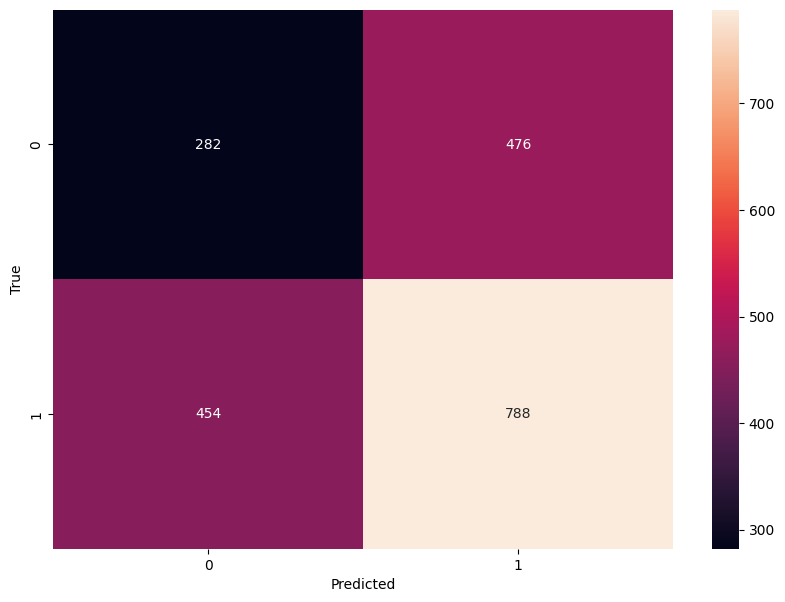

In [9]:
# 혼동행렬



from sklearn.metrics import confusion_matrix
# 혼동 행렬 계산
cm = confusion_matrix(y_val, y_val_pred)

# 혼동 행렬 시각화
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='g')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

In [10]:
from sklearn.metrics import classification_report

# 클래스별 성능 지표 출력
print(classification_report(y_val, y_val_pred))

              precision    recall  f1-score   support

           0       0.38      0.37      0.38       758
           1       0.62      0.63      0.63      1242

    accuracy                           0.54      2000
   macro avg       0.50      0.50      0.50      2000
weighted avg       0.53      0.54      0.53      2000



In [11]:
y_pred = knn_model.predict(new_x)
pd.DataFrame(y_pred)[0].value_counts()

1    6588
0    3412
Name: 0, dtype: int64

In [13]:
df_sub['target'] = y_pred
df_sub.set_index('user_id').to_csv('knn_optuna.csv', encoding="cp949")